# 경험적 PDF 함수

경험적 데이터에서 PDF, CDF, SF를 계산하는 방법.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

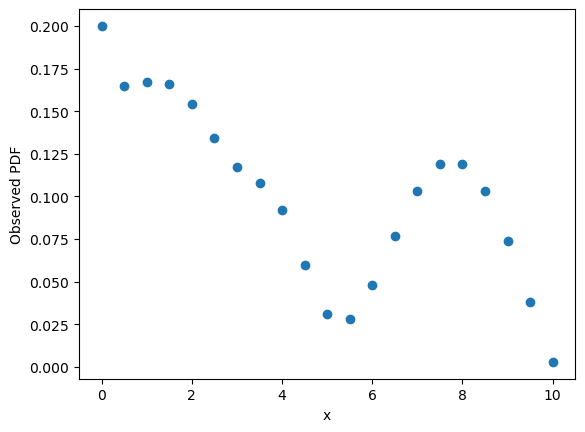

In [2]:
xs = [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 
      5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0]
ys = [0.2, 0.165, 0.167, 0.166, 0.154, 0.134, 0.117, 
      0.108, 0.092, 0.06, 0.031, 0.028, 0.048, 0.077, 
      0.103, 0.119, 0.119, 0.103, 0.074, 0.038, 0.003]

plt.scatter(xs, ys)
plt.xlabel("x")
plt.ylabel("Observed PDF");

이것이 희소한 관측치만 있는 연속 함수라고 가정하면, 빈칸을 어떻게 채울 수 있을까?

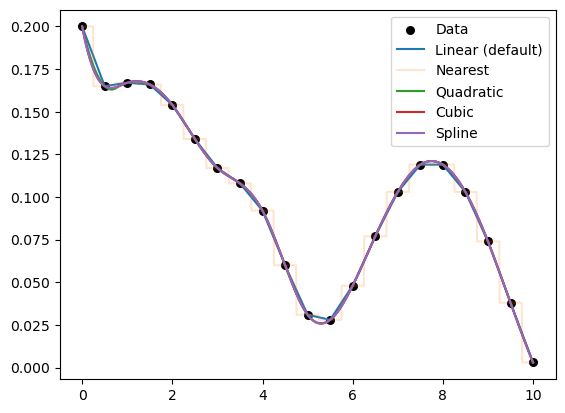

In [9]:
x = np.linspace(min(xs), max(xs), 1000)
y1 = interp1d(xs, ys)(x)
y2 = interp1d(xs, ys, kind="nearest")(x)
y3 = interp1d(xs, ys, kind="quadratic")(x)
y4 = interp1d(xs, ys, kind="cubic")(x)

from scipy.interpolate import splev, splrep
y5 = splev(x, splrep(xs, ys))

plt.scatter(xs, ys, s=30, label="Data", c="black")
plt.plot(x, y1, label="Linear (default)") #선형 보간: 모든 데이터 포인트 사이를 선형으로 보간
plt.plot(x, y2, label="Nearest", alpha=0.2) #요청한 x에서 가까운 값을 표시: 이산함수에서만 유용할 뿐, 연속함수에서는 단점
plt.plot(x, y3, label="Quadratic", ls='-')
plt.plot(x, y4, label="Cubic", ls='-')
plt.plot(x, y5, label="Spline", ls='-', alpha=1)
plt.legend();

interp1d를 사용하면 이제 어떤 x 값에 대해서도 확률 값을 찾을 수 있다.

CDF와 두 경계 사이의 값을 찾을 확률은 어떻게 계산할까? scipy.integrate를 사용하면 된다. Scipy가 다시 도움을 준다!

선택지는 여러 가지가 있다:

scipy.integrate.trapz – 낮은 정확도, 빠른 속도. 정확도는 O(h)에 비례.

scipy.integrate.simps – 중간 정도 정확도, 꽤 빠른 속도. 정확도는 O(h^2)에 비례.

scipy.integrate.quad – 높은 정확도, 느린 속도. 임의 정확도 가능.

호기심이 있다면 더 많은 함수도 찾아볼 수 있다.

In [7]:
from scipy.integrate import simps

def get_prob(xs, ys, a, b, resolution=1000):
    x_norm = np.linspace(min(xs), max(xs), resolution)
    y_norm = interp1d(xs, ys, kind="quadratic")(x_norm)
    normalisation = simps(y_norm, x=x_norm)
    x_vals = np.linspace(a, b, resolution)
    y_vals = interp1d(xs, ys, kind="quadratic")(x_vals)
    return simps(y_vals, x=x_vals) / normalisation

def get_cdf(xs, ys, v):
    return get_prob(xs, ys, min(xs), v)

def get_sf(xs, ys, v):
    return 1 - get_cdf(xs, ys, v)

print(get_prob(xs, ys, 0, 10))

1.0


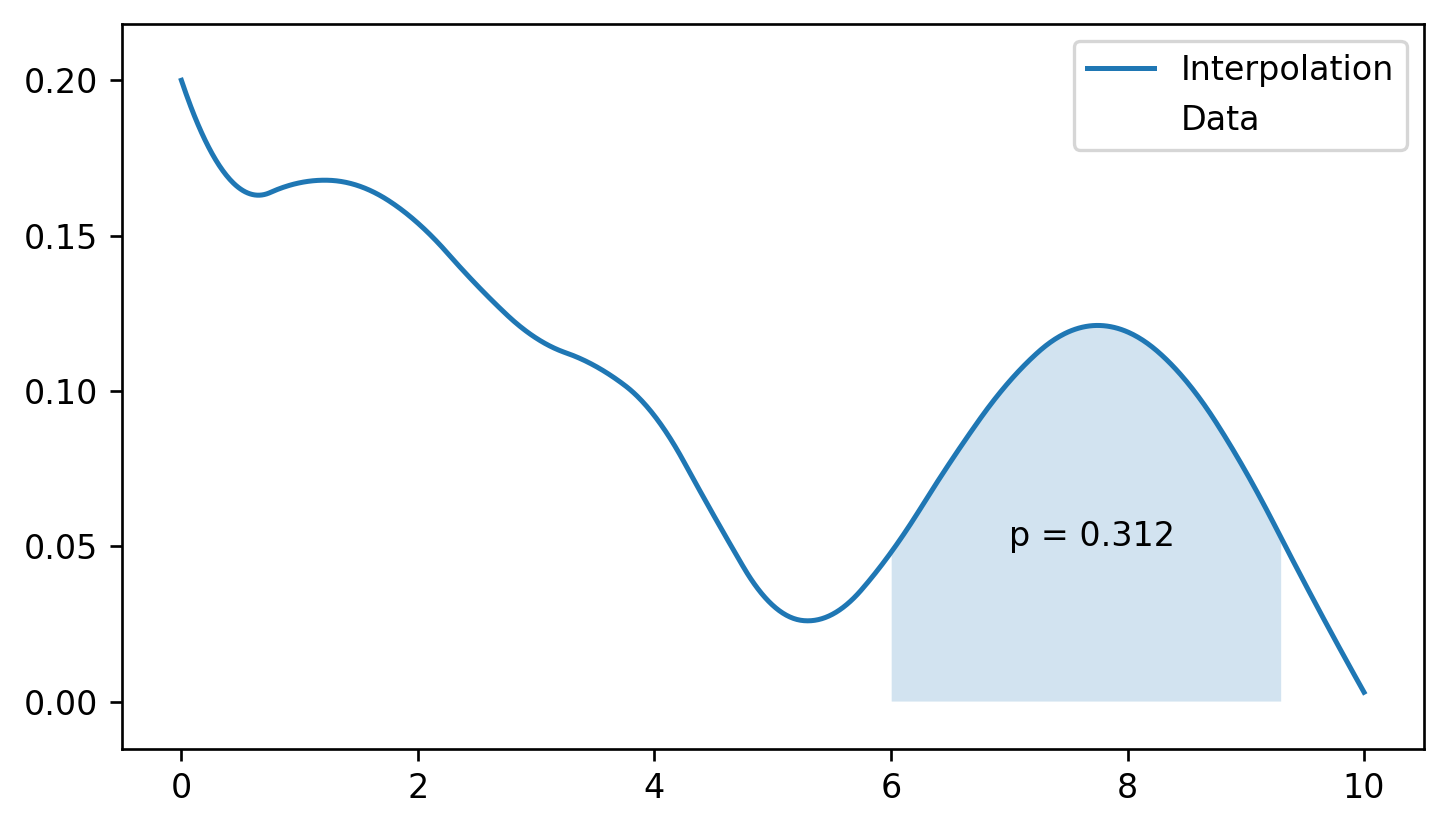

In [5]:
v1, v2 = 6, 9.3
area = get_prob(xs, ys, v1, v2)

plt.scatter(xs, ys, s=30, label="Data", color="w")
plt.plot(x, y3, linestyle="-", label="Interpolation")
plt.fill_between(x, 0, y3, where=(x>=v1)&(x<=v2), alpha=0.2)
plt.annotate(f"p = {area:.3f}", (7, 0.05))
plt.legend();

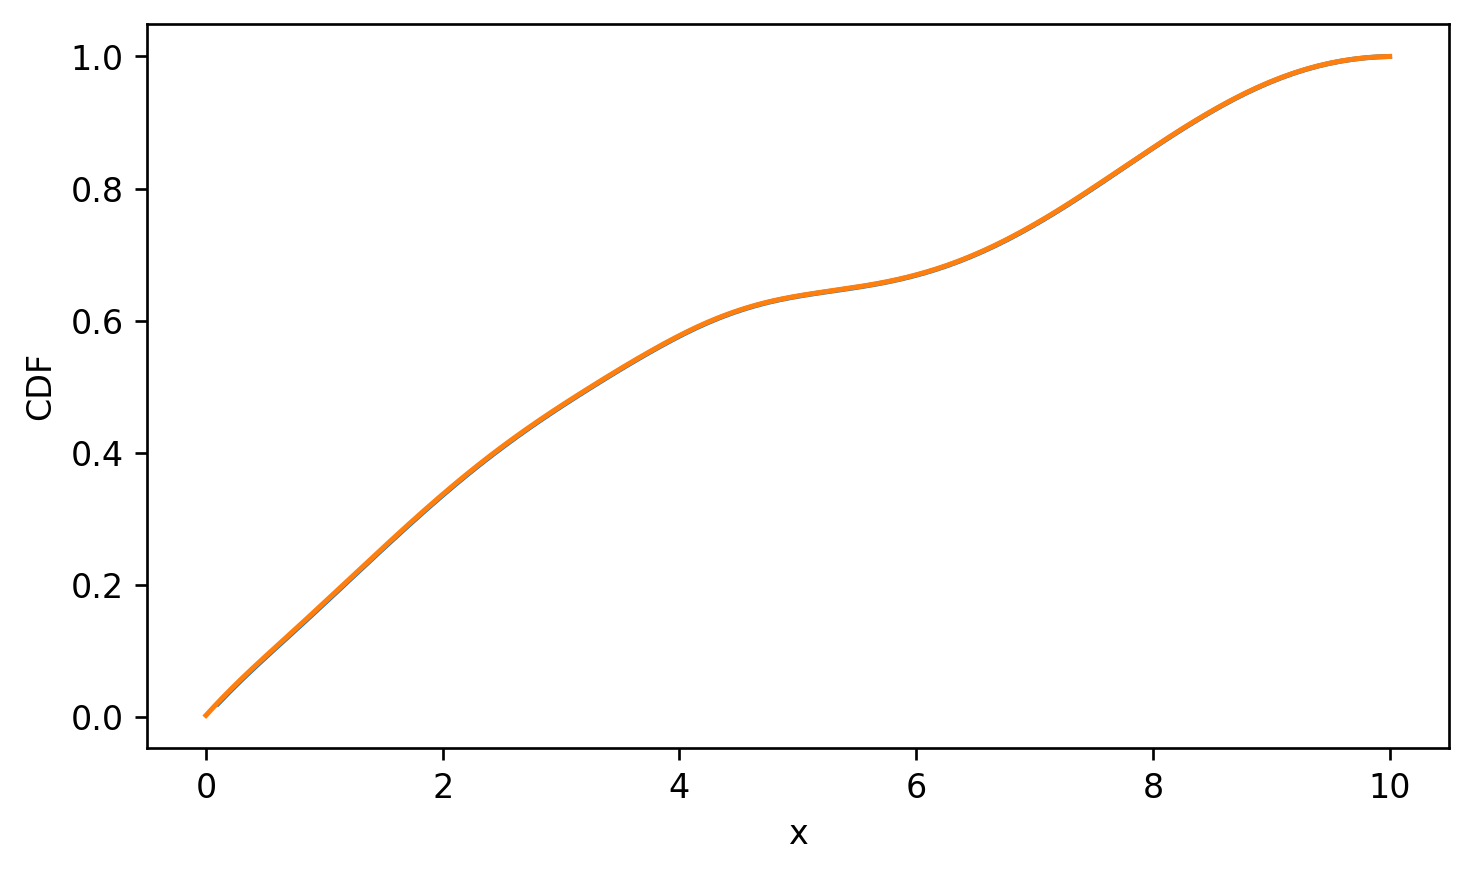

In [8]:
x_new = np.linspace(min(xs), max(xs), 100)
cdf_new = [get_cdf(xs, ys, i) for i in x_new]
cheap_cdf = y3.cumsum() / y3.sum()

plt.plot(x_new, cdf_new, label="Interpolated CDF")
plt.plot(x, cheap_cdf, label="Super cheap CDF for specific cases")
plt.ylabel("CDF")
plt.xlabel("x");

여기서 구현한 CDF 메서드는 단순하고 깔끔하지만, 엄청 느리다.

정확하게 해야 한다면 CDF 함수를 한 번만 높은 정확도로 계산하고 그 결과를 저장한 후, 필요할 때마다 보간(interpolate)하는 것이 좋다. 매번 다시 계산하는 것은 CPU 시간을 낭비하는 것이다. 사실 대부분의 경우, 충분한 점이 있는 배열이라면 cumsum() 방식으로도 충분하다.